In [22]:
import math

import h5py
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import torch
from scipy.interpolate import RegularGridInterpolator
from pathlib import Path
import re
import itertools

from SIREN_utils import (
    plot_complex_matrix,
    get_interpolated_matrix,
    fold_OP_mat,
    unfold_OP_mat,
    get_diagonal_line,
    reformat_diagonal,
    extract_diagonals,
    reformat_matrix_from_diagonals,
    get_V_coords,
    check_D4_symmetries
)

In [23]:
plt.style.use(["science", "notebook", "grid"])

In [24]:
# helper function to convert an MxM matrix into a sequence of flattened vectors
def make_2x2_matrices(array: np.ndarray) -> np.ndarray:
    # array should be of shape (2L^2, 2L^2)
    m_dim = 2

    # first we need to find L
    two_L_square = array.shape[0]
    L_square = two_L_square // m_dim
    L = int(round(math.sqrt(L_square)))

    # flatten alpha indices
    folded_array = fold_OP_mat(array)  # should be of shape (L^2, L^2, 2, 2)

    # get diagonal matrices
    diag_list = extract_diagonals(folded_array)

    # reshape them for the NN
    new_list = []
    for diagonal_matrix in diag_list:
        # diagonal_matrix should be of shape (L, L, 2, 2)
        new_list.append(diagonal_matrix.reshape((L**2, 4)))

    new_list = np.concatenate(new_list, axis=-1)
    return new_list

In [4]:
def get_indices_dict(OP_mat: np.ndarray) -> dict:
    data_dict = {}

    # for both central and off- diagonals:
    for index, diag in enumerate(extract_diagonals(fold_OP_mat(OP_mat))):
        diag_indices = []

        # iterate over the 2x2 matrix
        for i, j in itertools.product((0, 1), repeat=2):
            # check if empty
            diagonal_matrix = diag[:, :, i, j]
            if np.max(np.abs(diagonal_matrix)) > 0.1:
                diag_indices.append((i, j))
        
        data_dict[f"diag_{index+1}"] = diag_indices
    return data_dict

In [ ]:
def get_OP_dataset(L, pattern_representative, label="U_1_ground_state"):
    # pattern representative should be of shape (2L_rep^2, 2L_rep^2)
    L_rep = int(round(math.sqrt(pattern_representative.shape[0] / 2)))

    pattern = re.compile(rf"^L_{L}_U_1_number_of_random_initials_(\d+)_occupied_{int(((L ** 2) / 2))}_{int(((L ** 2) / 2))}__index_(\d+)_new$")
    base_dir = Path(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/{label}")

    # find the lowest energy
    min_energy = float("inf")
    reference_OP = None
    for folder in base_dir.iterdir():
        if folder.is_dir() and pattern.match(folder.name):
            results_filename = folder / "P_HF_result.h5"
            with h5py.File(results_filename, 'r') as results_file:
                num_samples = sum(1 for k in results_file.keys() if k.startswith("P_HF_result_"))
                for i in range(1, num_samples + 1):
                    try:
                        # find the energy
                        energy = (
                            results_file[f"HF_energy_per_unit_cell_{i}"][()].item().real
                        )
                    except KeyError:
                        continue

                    if energy - min_energy < 1e-4:
                        # get the OP for this initial
                        results_OP = np.transpose(
                            results_file[f"P_HF_result_{i}"][()]
                        ).conj()

                        # check interpolation
                        test_OP = get_interpolated_matrix(results_OP, L_rep)
                        max_abs = np.max(np.abs(test_OP - pattern_representative))
                        if max_abs < 0.4:  # means it has the same pattern
                            reference_OP = results_OP

                        if energy < min_energy:
                            min_energy = energy

    print(f"Minimum Energy: {min_energy}")

    sequence_list = []

    for folder in base_dir.iterdir():
        if folder.is_dir() and pattern.match(folder.name):
            # print("hello")
            with h5py.File(folder / "P_HF_initial.h5", 'r') as initials_file:
                with h5py.File(folder / "P_HF_result.h5", 'r') as results_file:
                    num_samples = sum(1 for k in results_file.keys() if k.startswith("P_HF_result_"))
                    for i in range(1, num_samples + 1):
                        print(f"\rIndex: {i}", end="", flush=True)
                        try:
                            # check if its in the lowest energy band and matches the pattern
                            energy = (
                                results_file[f"HF_energy_per_unit_cell_{i}"][()].item().real
                            )
                            if energy - min_energy < 1e-4:
                                results_OP = np.transpose(
                                    results_file[f"P_HF_result_{i}"][()]
                                ).conj()

                                if np.max(np.abs(results_OP - reference_OP)) < 0.01:
                                    initial_OP = np.transpose(
                                        initials_file[f"P_initial_{i}"][()]
                                    ).conj()

                                    sequence_list.append(
                                        np.array(
                                            [
                                                make_2x2_matrices(initial_OP),
                                                make_2x2_matrices(results_OP),
                                            ]
                                        )
                                    )
                        except KeyError:
                            continue

    sequence_list = np.array(sequence_list, dtype=np.float32)

    # randomly shuffle the combined dataset
    rng = np.random.default_rng()
    rng.shuffle(sequence_list, axis=0)

    # now save to file
    with h5py.File(
        f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/{label}/hubbard_model_lowest_energy_{L}x{L}_{label}.h5",
        "w",
    ) as dataset_file:
        dataset_file.create_dataset(
            name="dataset", data=sequence_list, dtype=np.float32
        )

    print(f"\nFinal shape: {sequence_list.shape}")
    print(f"Data type: {sequence_list.dtype}")

    return reference_OP

In [26]:
def get_best_OP_mat(L: int, base_dir = "/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/U_1_ground_state"):
    pattern = re.compile(rf"^L_{L}_U_1_number_of_random_initials_(\d+)_occupied_{int(((L ** 2) / 2))}_{int(((L ** 2) / 2))}__index_(\d+)_new$")

    base_dir = Path(base_dir)

    # get the OP with the lowest energy
    min_energy = float("inf")
    best_OP = None

    # iterate over all the folders
    for folder in base_dir.iterdir():
        if folder.is_dir() and pattern.match(folder.name):
            results_filename = folder / "P_HF_result.h5"
            with h5py.File(results_filename, 'r') as results_file:
                num_samples = sum(1 for k in results_file.keys() if k.startswith("P_HF_result_"))
                for i in range(1, num_samples + 1):
                    try:
                        energy = (
                            results_file[f"HF_energy_per_unit_cell_{i}"][()].item().real
                        )
                        if energy < min_energy:
                            min_energy = energy
                            best_OP = np.transpose(
                                results_file[f"P_HF_result_{i}"][()]
                            ).conj()
                    except KeyError:
                        continue

    print(f"Minimum Energy: {min_energy}")
    return best_OP

Minimum Energy: -0.5655891666243236
Minimum Energy: -0.5677041362542791


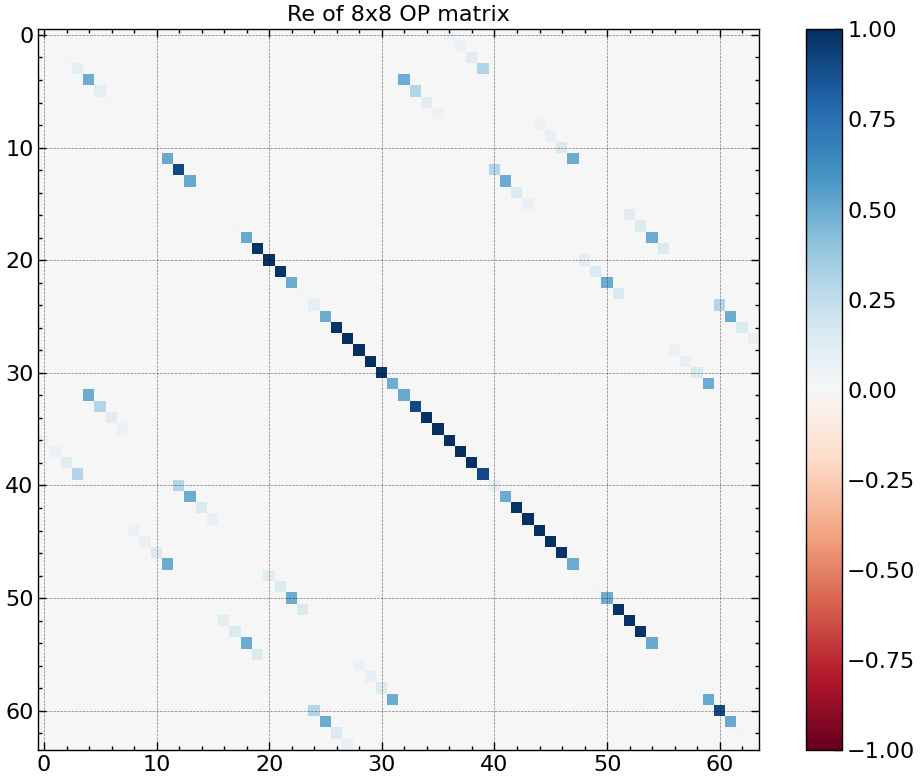

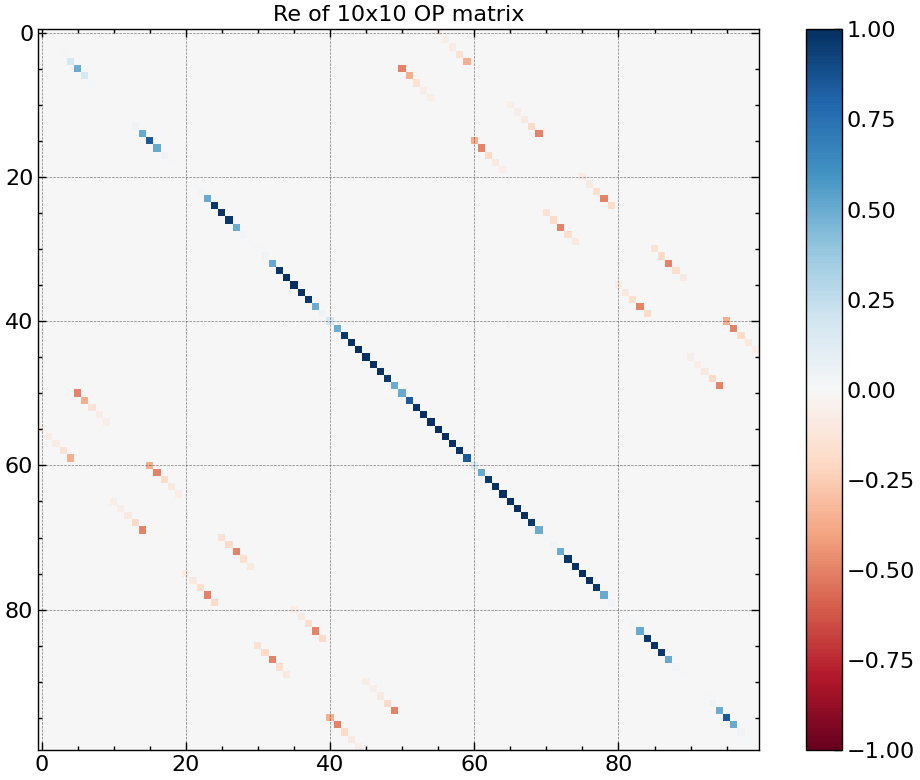

In [27]:
OP_8x8 = get_best_OP_mat(L=8)
OP_10x10 = get_best_OP_mat(L=10)
plot_complex_matrix(fold_OP_mat(OP_8x8)[:, :, 1, 1], title="8x8 OP matrix")
plot_complex_matrix(fold_OP_mat(OP_10x10)[:, :, 1, 1], title="10x10 OP matrix")

In [28]:
pattern_representative = OP_8x8

# make all the datasets at once
# get_OP_dataset(30, pattern_representative)
get_OP_dataset(6, pattern_representative)

Minimum Energy: -0.560388744891663
hello
Index: 1725hello
Index: 2500hello
Index: 2500hello
Index: 1658hello
Index: 1384hello
Index: 2500hello
Index: 2500hello
Index: 1493
Final shape: (147, 2, 36, 8)
Data type: float32


array([[ 3.28437542e-03-1.08647901e-32j,  0.00000000e+00-0.00000000e+00j,
        -6.86109204e-10+3.01983702e-09j, ...,
         0.00000000e+00+0.00000000e+00j, -1.15302425e-10-1.09936175e-10j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  3.27981357e-03-2.07132470e-28j,
         0.00000000e+00-0.00000000e+00j, ...,
        -2.51723109e-08+1.72678702e-08j,  0.00000000e+00-0.00000000e+00j,
         5.95725260e-07-3.20588009e-07j],
       [-6.86109204e-10-3.01983702e-09j,  0.00000000e+00+0.00000000e+00j,
         5.79461665e-03+4.20122083e-20j, ...,
         0.00000000e+00+0.00000000e+00j, -2.11036787e-10+7.37257269e-11j,
         0.00000000e+00-0.00000000e+00j],
       ...,
       [ 0.00000000e+00-0.00000000e+00j, -2.51723109e-08-1.72678702e-08j,
         0.00000000e+00-0.00000000e+00j, ...,
         5.00000000e-01+1.92114160e-18j,  0.00000000e+00+0.00000000e+00j,
         1.39047844e-07-1.16124227e-07j],
       [-1.15302425e-10+1.09936175e-10j,  0.

In [29]:
def check_pattern(L, label="U_1_ground_state"):
    with h5py.File(
        # f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/{label}/hubbard_model_lowest_energy_{L}x{L}_fixed_combined.h5",
        f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/{label}/hubbard_model_lowest_energy_{L}x{L}_{label}.h5",
        "r",
    ) as f:
        tensor = f["dataset"][()][0, 1, :, :]
        print(tensor.shape)
        diag_list = (
            tensor[:, :4].reshape((L, L, 2, 2)),
            tensor[:, 4:].reshape((L, L, 2, 2)),
        )

    return reformat_matrix_from_diagonals(diag_list)

(36, 8)


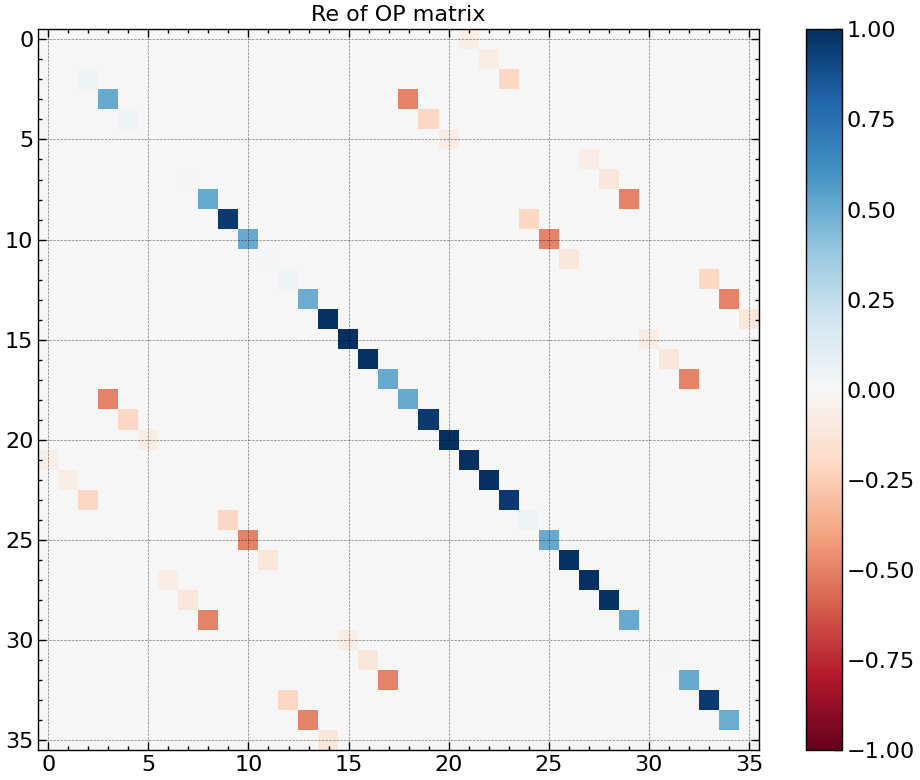

In [30]:
test_6x6 = check_pattern(6)
plot_complex_matrix(test_6x6[:, :, 0, 0])

(900, 8)


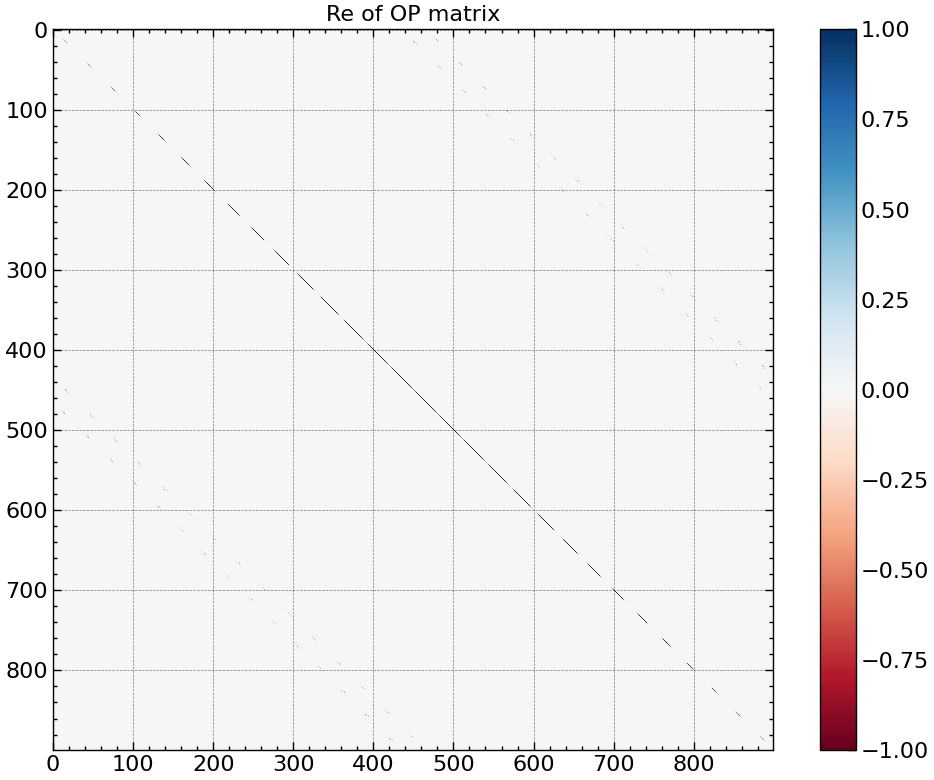

In [44]:
test_30x30 = check_pattern(30)
plot_complex_matrix(test_30x30[:, :, 0, 0])

(64, 8)
(100, 8)
(324, 8)


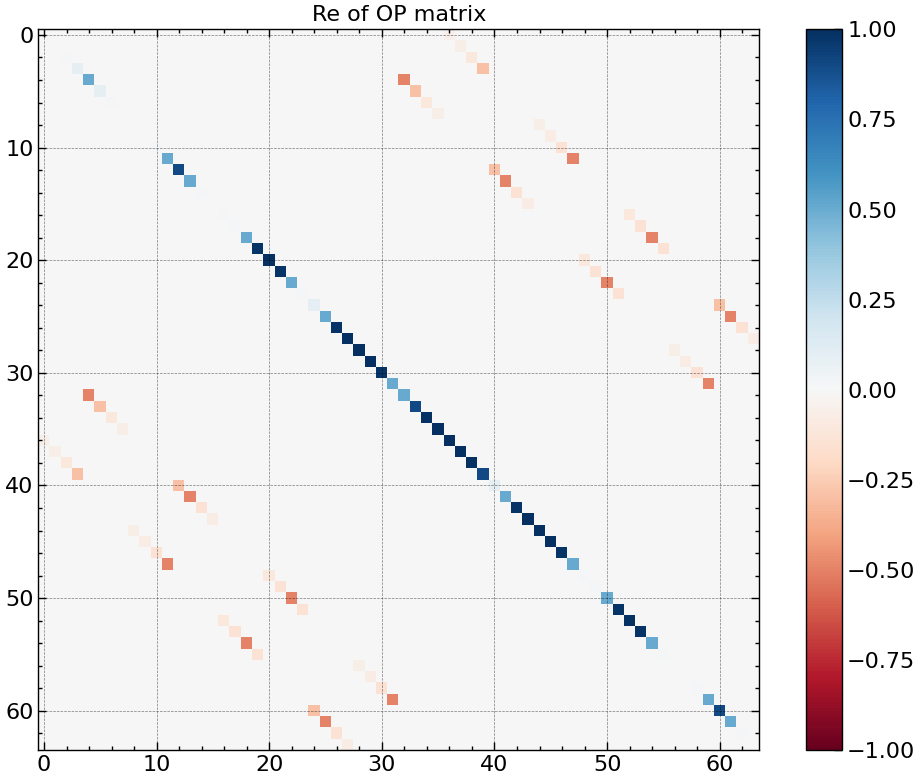

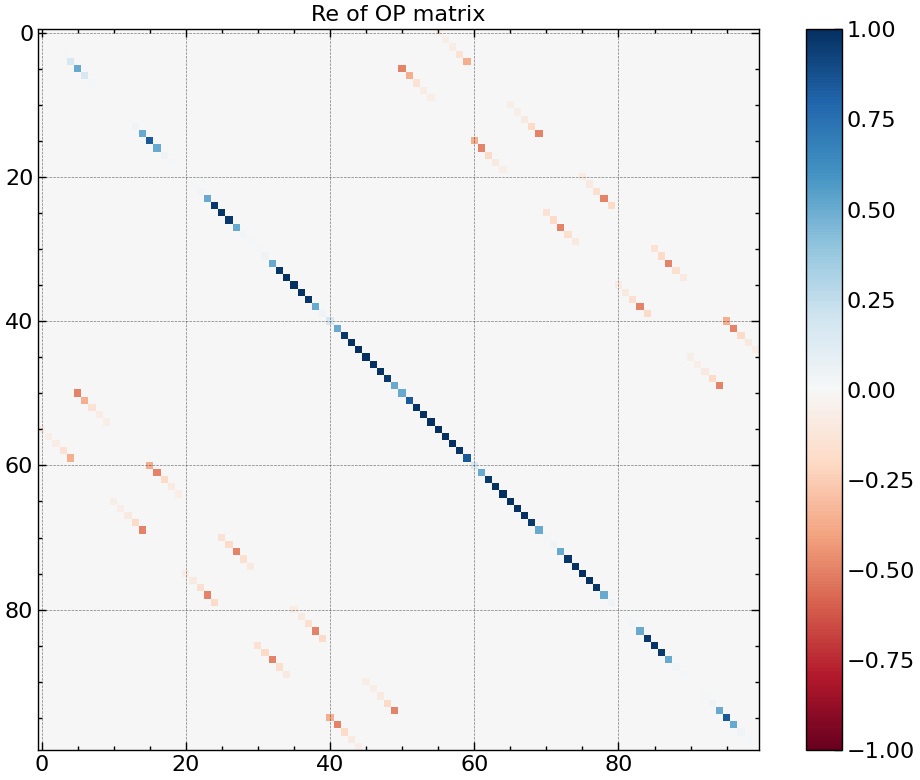

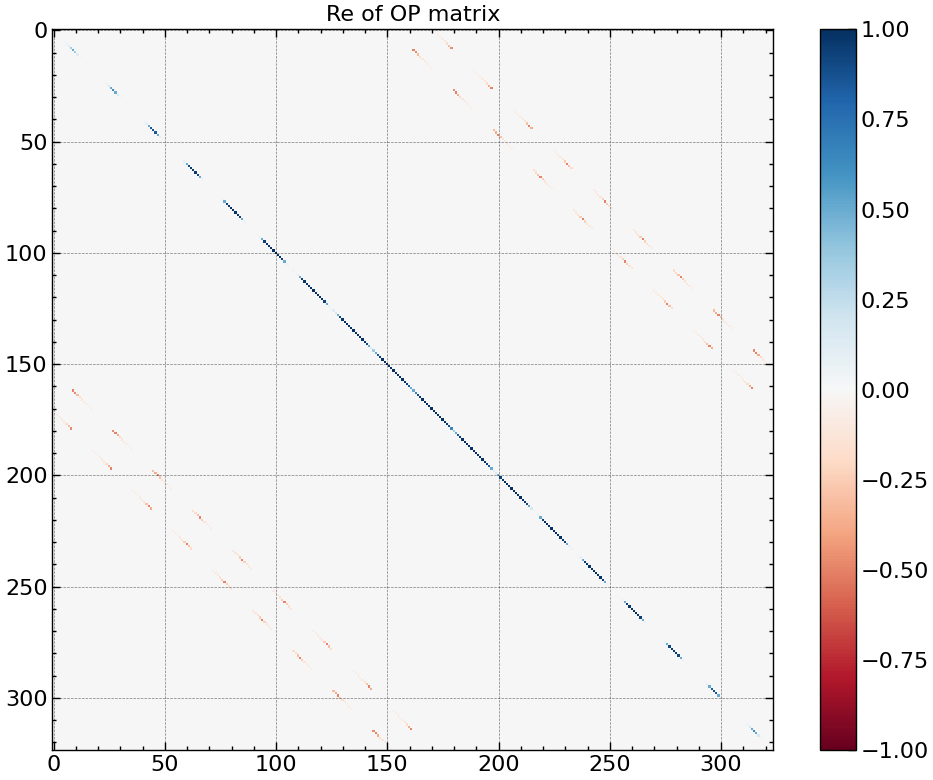

In [17]:
test_8x8 = check_pattern(8)
test_10x10 = check_pattern(10)
test_18x18 = check_pattern(18)

# now plot them
plot_complex_matrix(test_8x8[:, :, 0, 0])
plot_complex_matrix(test_10x10[:, :, 0, 0])
plot_complex_matrix(test_18x18[:, :, 0, 0])